# Plot transit time along shelf

In [5]:
import xarray as xr
import numpy as np
from glob import glob


# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm # beautiful colour maps
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from dask.distributed import Client
import memory_profiler

import warnings
warnings.filterwarnings("ignore")

In [6]:
import sys
from pathlib import Path
# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] )
if module_path not in sys.path:
    sys.path.append(module_path)
import custom_functions as cf

In [7]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 18,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39471,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 18
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:33013,Total threads: 3
Dashboard: /proxy/36177/status,Memory: 33.33 GiB
Nanny: tcp://127.0.0.1:39903,


## Load data

- Transit time data files
- Distance along contour files/masks
- Lat and lon along contour files
- Coarse basin masks (for plotting)

In [8]:
# 1: Transit time datafiles
#datafiles = sorted(glob('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/TransitTime_dist_along_contour_*_forfig_6monthbins.nc'))
datafiles = sorted(glob('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/TransitTime_dist_along_contour_*_forfig_6monthbins_Gamma-10.nc'))

# 2: Distance along contour files
distmaskfiles = sorted(glob('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/contour_distance/along_contour_distance_mask_*.nc'))

# 3: Lat and lon along 1000m isobath contour
latlonfiles = sorted(glob('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/contour_distance/lat_lon_contour_distance_*.nc'))

# 4: coarse basin masks
maskfile = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/Antarctic_shelf_basin_mask_hu_coarse.nc'
mask = xr.open_dataset(maskfile)
mask['basins'] = mask.basins.where(mask.basins != 100, np.nan)

## Define plotting functions

In [9]:
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht[:1000,:] 
hu = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').hu[:509,:] 
land_mask = (hu*0).fillna(1)
land_mask_masked = land_mask.where(land_mask == 1)
land_mask[300:, 800:1000] = 0
land_mask[355:,5:140] = 0
land_mask[225:, 1800:2000] = 0
yu_ocean = hu.yu_ocean.values
yu_ocean[0] = -90
xu_ocean = hu.xu_ocean.values
hu_shelf, shelf_mask = cf.shelf_mask_isobath(hu)



labelfs = 14
tickmarkfs = 13

wapmarker = '^'
wapmarkersize = 500
wapmarkercol = 'm'
rossmarkercol='k'
ls_pct = '-'
col_pct = 'orangered'
col_median = 'royalblue'
col_peak='navy'
iqrcol = 'royalblue'
iqralpha = 0.15
lw_pct = 1
basincol='r'
basinalpha=0.7

distmarker='o'
distmarkersize = 70
distmarkercol = 'k'


# legend elements
line1 = Line2D([0], [0], color=col_peak, linestyle='-', linewidth=2.5)
line2 = Line2D([0], [0], color=col_median, linestyle='--', linewidth=1.8)
line3 = Line2D([0], [0], color=col_pct, linestyle=ls_pct, linewidth=lw_pct)
m_triangle = Line2D([], [], color='m', marker='^', linestyle='None',
                          markersize=10, )
k_triangle = Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=10, )
green_circle = Line2D([], [], color='g', marker='o',markeredgecolor='k', linestyle='',
                          markersize=10, )

labels = ['Peak arrival', 
          'Median arrival',
          'Interquartile range', 
          'Particle %', 
          'Antarctic Peninsula',
          'Cape Adare'
         ]
bluepatch = mpatches.Patch(fc='blue', alpha=0.1, ec='blue')

subplot_labels = ['a)', 'b)', 'c)','d)', 'e)']
extent = [-180, 180, -79, -64]

In [13]:
def stereo_plot(axes, extent, basinid):
    '''
    Return Antarctic stereographic plot on axes
    '''
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axes.set_extent(extent, crs=ccrs.PlateCarree())
    #axes.set_boundary(circle, transform=axes.transAxes)
    
    # plot land and shelf contours
    axes.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], 
                 colors='k', linewidths=1, zorder=3, alpha = 1, transform = ccrs.PlateCarree())
    axes.contourf(xu_ocean, yu_ocean, land_mask_masked.values, [0,1], zorder=1,
                 colors='silver', alpha=1, linewidths=1.2, transform = ccrs.PlateCarree())
    axes.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], zorder=1,
                 colors='dimgrey', alpha=1, linewidths=0.5, transform = ccrs.PlateCarree())
    
    # specifying xlocs/ylocs yields number of meridian/parallel lines
    dmeridian = 45  # spacing for lines of meridian
    dparallel = 10  # spacing for lines of parallel 
    num_merid = int(360/dmeridian + 1)
    num_parra = int(90/dparallel + 1)
    
    gl = axes.gridlines(crs=ccrs.PlateCarree(), 
                        xlocs=np.linspace(-180, 180, num_merid), \
                        ylocs=np.linspace(-90, 0, num_parra), \
                        #draw_labels=True,
                        draw_labels=False,
                        linewidth=1, color='grey', alpha=0.5, linestyle=':')
    return 
    
def time_vs_dist_plot(ds, axes, xlim, ylim1, ylim2, idx1, idx2):
    #axes.plot(ds.distance, ds.time_peak, c=col_peak, lw = 2.5, alpha=1, zorder=2)
    axes.plot(ds.distance, ds.time_peak_gaussian, c=col_peak, lw = 2.5,alpha=1, zorder=2)
    axes.plot(ds.distance, ds.time_median, c=col_median, ls = '--',lw = 1.8, alpha=1, zorder=1)
    axes.fill_between(ds.distance, ds.time_median, 
                      ds.iqr25, color=iqrcol, alpha=iqralpha, zorder=1)
    axes.fill_between(ds.distance, ds.time_median, 
                      ds.iqr75, color=iqrcol, alpha=iqralpha, zorder=1)
    axes.fill_between([xlim,22], 25, 0, color=basincol, alpha=basinalpha)
    axes.set_xlim([0,21])
    axes.set_ylim([0,ylim1])
    axes.set_ylabel('Time (years)', fontsize = labelfs)
    axes.set_yticks([0,3,6,9,12,15,18,21])
    axes.set_yticklabels([0,3,6,9,12,15,18,21], fontsize = tickmarkfs)
    #axes.set_xticklabels([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], fontsize = tickmarkfs)
    axes2 = axes.twinx()
    axes2.plot(ds.distance, ds.particle_transpct, linestyle = ls_pct, c = col_pct, lw=lw_pct,zorder=1)
    #axes2.plot([0,22], [1,1], linestyle = ls_threshold, c = col_threshold, lw=lw_threshold,zorder=1)
    axes2.scatter(latlon.distance[idx1], 0, marker=wapmarker, s=wapmarkersize, c=wapmarkercol, edgecolor = 'm',zorder=3)
    axes2.scatter(latlon.distance[idx2], 0, marker=wapmarker, s=wapmarkersize, c=rossmarkercol, zorder=3)
    axes2.set_ylim([0,ylim2])
    axes2.set_ylabel('% of intitial particle release', fontsize = labelfs)            
    return axes2


def plot_sector_contour(ax2, ax4, ax6, ax8, ax10):
    basinalph = 0.6
    basincol = 'r'
    lw = 4
    ax10.contour(xu_ocean[2700:], yu_ocean, land_mask[:,2700:].values, [0,1], zorder=2,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax10.contour(xu_ocean[0:140], yu_ocean, land_mask[:,0:140].values, [0,1], zorder=2,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax8.contour(xu_ocean[140:920], yu_ocean[225:], land_mask[225:,140:920].values, [0,1], zorder=2,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax6.contour(xu_ocean[820:1430], yu_ocean[:223], land_mask[:223,820:1430].values, [0,1], zorder=2,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax4.contour(xu_ocean[1431:2179], yu_ocean[:400], land_mask[:400,1431:2179].values, [0,1], zorder=2,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax2.contour(xu_ocean[2180:2700], yu_ocean[:395], land_mask[:395,2180:2700].values, [0,1], zorder=2,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax2.contour(xu_ocean[2203:2300], yu_ocean[394:408], land_mask[394:408,2203:2300].values, [0,1], zorder=2,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax2.contour(xu_ocean[2214:2300], yu_ocean[408:418], land_mask[408:418,2214:2300].values, [0,1], zorder=2,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax2.contour(xu_ocean[2235:2300], yu_ocean[418:426], land_mask[418:426,2235:2300].values, [0,1], zorder=2,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    return

def plot_twin_ax(twinax, yticks):
    twinax.set_yticks(yticks)
    twinax.set_yticklabels(yticks, fontsize = tickmarkfs)
    twinax.spines['right'].set_color(col_pct)
    twinax.yaxis.label.set_color(col_pct)
    twinax.tick_params(axis='y', colors=col_pct)
    twinax.spines['left'].set_color('darkblue')
    
    return 

def plot_distance_markers(ax, latlon):
    d = 0
    for i in range(6):
        idx = np.where(latlon.distance == d)[0]
        ax.scatter(latlon.lon[idx], latlon.lat[idx], facecolor=distmarkercol, edgecolor='k', alpha=1, zorder=3,
                    marker=distmarker, s=distmarkersize, transform=ccrs.PlateCarree())
        #if d ==0 or d == 16 or d == 20:
        #    ax.text(latlon.lon[idx]+2, latlon.lat[idx]+1, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
        #elif d == 4:
        #     ax.text(latlon.lon[idx]-8, latlon.lat[idx]+0.5, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())   
        #else:
        if latlon.lon[idx] < -180:
            ax.text(latlon.lon[idx], latlon.lat[idx]+2, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
        else:
            ax.text(latlon.lon[idx], latlon.lat[idx]+2, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
        d += 4

## Plot figure

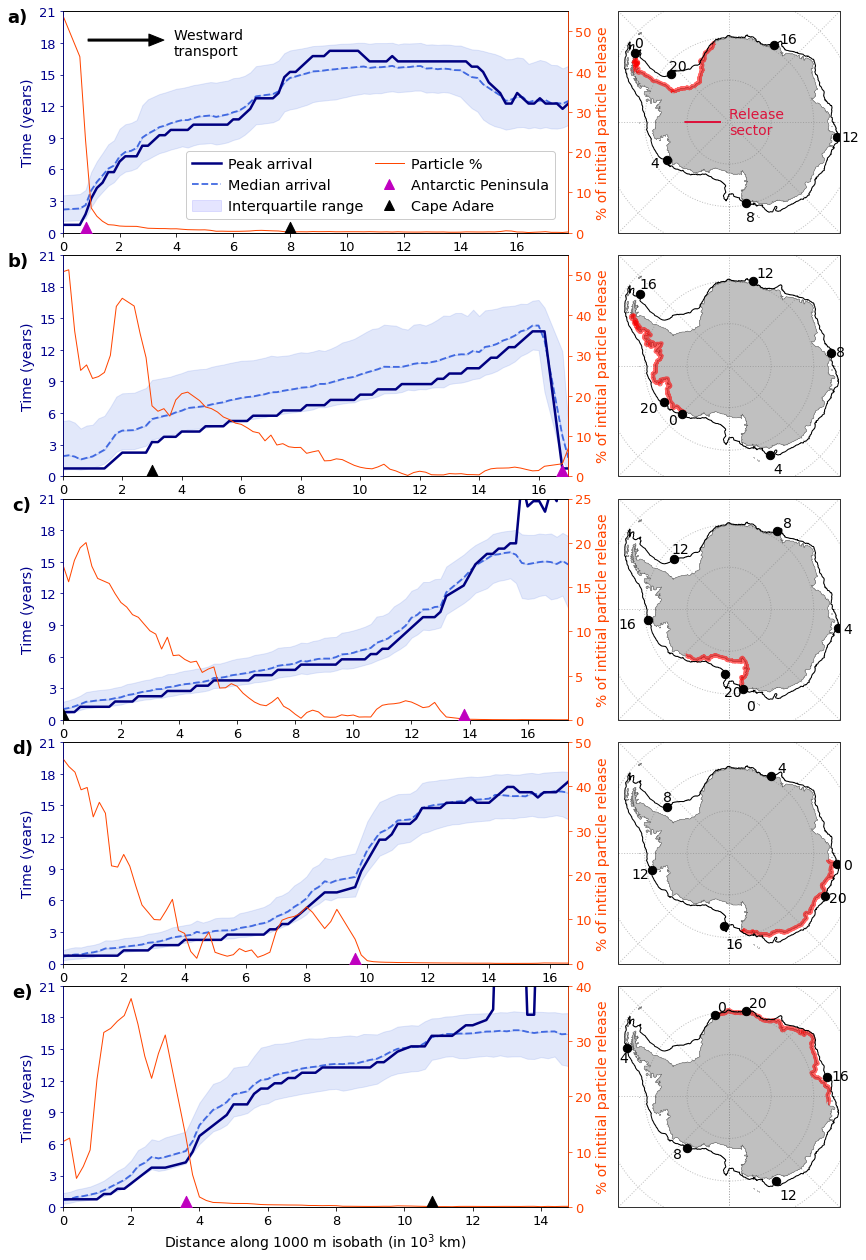

In [15]:
fig = plt.figure(constrained_layout=True, figsize=(14,22))
spec1 = gridspec.GridSpec(ncols=3, nrows=5, figure=fig)
ax1 = fig.add_subplot(spec1[0, 0:2])
ax2 = fig.add_subplot(spec1[0, 2], projection=ccrs.SouthPolarStereo(central_longitude=0))
ax3 = fig.add_subplot(spec1[1,0:2], )
ax4 = fig.add_subplot(spec1[1,2], projection=ccrs.SouthPolarStereo(central_longitude=0))
ax5 = fig.add_subplot(spec1[2,0:2],)
ax6 = fig.add_subplot(spec1[2,2], projection=ccrs.SouthPolarStereo(central_longitude=0))
ax7 = fig.add_subplot(spec1[3,0:2],)
ax8 = fig.add_subplot(spec1[3,2], projection=ccrs.SouthPolarStereo(central_longitude=0))
ax9 = fig.add_subplot(spec1[4,0:2], )
ax10= fig.add_subplot(spec1[4,2],projection=ccrs.SouthPolarStereo(central_longitude=0) )
fig.subplots_adjust(wspace=0.2, hspace=0.1)
#plt.rcParams.update({'font.family':'Arial'})

# Weddell Sea
i = 4
ds = xr.open_dataset(datafiles[i])
latlon = xr.open_dataset(latlonfiles[i+2])
idxwap = (np.abs(latlon.lon - (-59))).argmin()
idxross = (np.abs(latlon.lon - (-190))).argmin()
twinax = time_vs_dist_plot(ds, ax1, 17.78, 21, 55, idxwap, idxross)
plot_twin_ax(twinax, [0,10,20,30,40,50])
ax1.yaxis.label.set_color('darkblue')
ax1.tick_params(axis='y', colors='darkblue')
# plot map
stereo_plot(ax2, extent, 7)
for i,d in enumerate(np.arange(0,24,4)):
    idx = np.where(latlon.distance == d)[0]
    ax2.scatter(latlon.lon[idx], latlon.lat[idx], facecolor=distmarkercol, edgecolor='k', alpha=1, zorder=3,
                marker=distmarker, s=distmarkersize, transform=ccrs.PlateCarree())
    if d == 0 or d == 16 or d == 12 or d == 20:
        ax2.text(latlon.lon[idx]+2, latlon.lat[idx]+1, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    else:
        ax2.text(latlon.lon[idx]+2, latlon.lat[idx]+4, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())

# add legend
legend = twinax.legend([line1, line2, bluepatch, line3, m_triangle, k_triangle], labels, loc='upper left', ncol=2, 
                       frameon=True, bbox_to_anchor=(0.23, 0.4), fontsize = 'x-large', handletextpad=0.5, columnspacing=0.8)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 0.4))

# West Antarctica
i = 3
ds = xr.open_dataset(datafiles[i])
latlon = xr.open_dataset(latlonfiles[i+2])
idxwap = (np.abs(latlon.lon - (-56.8))).argmin()
idxross = (np.abs(latlon.lon - (-190))).argmin()
twinax = time_vs_dist_plot(ds, ax3, 17, 21, 55, idxwap, idxross)
plot_twin_ax(twinax, [0,10,20,30,40,50])
ax3.yaxis.label.set_color('darkblue')
ax3.tick_params(axis='y', colors='darkblue')
# plot map
stereo_plot(ax4, extent, 5)
for i,d in enumerate(np.arange(0,24,4)):
    idx = np.where(latlon.distance == d)[0]
    ax4.scatter(latlon.lon[idx], latlon.lat[idx], facecolor=distmarkercol, edgecolor='k', alpha=1, zorder=3,
                marker=distmarker, s=distmarkersize, transform=ccrs.PlateCarree())
    if d == 8 or d == 12 or d == 16:
        ax4.text(latlon.lon[idx]+2, latlon.lat[idx]+1, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    elif d == 0 or d == 4:
        ax4.text(latlon.lon[idx]+2, latlon.lat[idx]+4, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    else:
        ax4.text(latlon.lon[idx]+2, latlon.lat[idx]+6, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())

# Ross Sea
i = 2
ds = xr.open_dataset(datafiles[i])
latlon = xr.open_dataset(latlonfiles[i+2])
idxwap = (np.abs(latlon.lon - (-57))).argmin()
idxross = (np.abs(latlon.lon - (-191))).argmin()
twinax = time_vs_dist_plot(ds, ax5, 17.45, 21, 25, idxwap, idxross)
plot_twin_ax(twinax, [0,5,10,15,20,25])
ax5.yaxis.label.set_color('darkblue')
ax5.tick_params(axis='y', colors='darkblue')
# plot map
stereo_plot(ax6, extent, 4)
for i,d in enumerate(np.arange(0,24,4)):
    idx = np.where(latlon.distance == d)[0]
    ax6.scatter(latlon.lon[idx], latlon.lat[idx], facecolor=distmarkercol, edgecolor='k', alpha=1, zorder=3,
                marker=distmarker, s=distmarkersize, transform=ccrs.PlateCarree())
    if d == 4 or d == 8 or d == 12:
        ax6.text(latlon.lon[idx]+2, latlon.lat[idx]+1.5, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    elif d == 16:
        ax6.text(latlon.lon[idx]-2, latlon.lat[idx]+7, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    else:
        ax6.text(latlon.lon[idx], latlon.lat[idx]+5, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
        
# East Antarctica - East
i = 1
ds = xr.open_dataset(datafiles[i])
latlon = xr.open_dataset(latlonfiles[i+2])
idxwap = (np.abs(latlon.lon - (-57))).argmin()
idxross = (np.abs(latlon.lon - (-190))).argmin()
twinax = time_vs_dist_plot(ds, ax7, 16.65, 21, 50, idxwap,idxross)
plot_twin_ax(twinax, [0,10,20,30,40,50])
ax7.yaxis.label.set_color('darkblue')
ax7.tick_params(axis='y', colors='darkblue')
# plot map
stereo_plot(ax8, extent, 3)
for i,d in enumerate(np.arange(0,24,4)):
    idx = np.where(latlon.distance == d)[0]
    ax8.scatter(latlon.lon[idx], latlon.lat[idx], facecolor=distmarkercol, edgecolor='k', alpha=1, zorder=3,
                marker=distmarker, s=distmarkersize, transform=ccrs.PlateCarree())
    if d <=8 or d == 20:
        ax8.text(latlon.lon[idx]+2, latlon.lat[idx]+1.5, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    elif i ==16:
        ax8.text(latlon.lon[idx], latlon.lat[idx]+4, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    else:
        ax8.text(latlon.lon[idx]-2, latlon.lat[idx]+5, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())

# East Antarctica - West
i = 0
ds = xr.open_dataset(datafiles[i])
latlon = xr.open_dataset(latlonfiles[i+2])
idxwap = (np.abs(latlon.lon - (-57))).argmin()
idxross = (np.abs(latlon.lon - (-190))).argmin()
twinax = time_vs_dist_plot(ds, ax9, 14.85, 21, 40, idxwap, idxross)
plot_twin_ax(twinax, [0,10,20,30,40])
ax9.yaxis.label.set_color('darkblue')
ax9.tick_params(axis='y', colors='darkblue')
# plot map
stereo_plot(ax10, extent, 2)
for i,d in enumerate(np.arange(0,24,4)):
    idx = np.where(latlon.distance == d)[0]
    ax10.scatter(latlon.lon[idx], latlon.lat[idx], facecolor=distmarkercol, edgecolor='k', alpha=1, zorder=3,
                marker=distmarker, s=distmarkersize, transform=ccrs.PlateCarree())
    if d ==0 or d == 16 or d == 20:
        ax10.text(latlon.lon[idx]+2, latlon.lat[idx]+1, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    elif d == 4:
         ax10.text(latlon.lon[idx]-8, latlon.lat[idx]+0.5, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())   
    else:
        ax10.text(latlon.lon[idx]+3, latlon.lat[idx]+4, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())  
    

# label x-axis
ax9.set_xlabel('Distance along 1000 m isobath (in $10^{3}$ km)', fontsize = labelfs)

# contour release basin on map
plot_sector_contour(ax2, ax4, ax6, ax8, ax10)


# add arrows
ax1.text(3.9, 16.8, 'Westward \ntransport', color='k',fontsize=14)
ax1.annotate('',xy=(0.2, 0.87), xytext=(0.05, 0.87),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='k', ec='k', width=2, headwidth=12, headlength=15),
                 horizontalalignment='left', verticalalignment='center', fontsize=14)
ax2.annotate('',xy=(0.46, 0.5), xytext=(0.3, 0.5),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', width=1, headwidth=0, headlength=0.01),
                 horizontalalignment='left', verticalalignment='center', fontsize=14)
ax2.text(120, -90, 'Release \nsector', color='crimson',fontsize=14, verticalalignment='center', transform=ccrs.PlateCarree())

# subplot labels
ax1.text(-0.11, 0.95, subplot_labels[0], fontweight='bold', fontsize=18, transform=ax1.transAxes)
ax3.text(-0.11, 0.95, subplot_labels[1], fontweight='bold', fontsize=18, transform=ax3.transAxes)
ax5.text(-0.1, 0.95, subplot_labels[2], fontweight='bold', fontsize=18, transform=ax5.transAxes)
ax7.text(-0.1, 0.95, subplot_labels[3], fontweight='bold', fontsize=18, transform=ax7.transAxes)
ax9.text(-0.1, 0.95, subplot_labels[4], fontweight='bold', fontsize=18, transform=ax9.transAxes)

# Set xlimits
ax9.set_xlim([0,14.8])
ax7.set_xlim([0,16.6])
ax5.set_xlim([0,17.4])
ax3.set_xlim([0,17])
ax1.set_xlim([0,17.8])
ax9.set_xticklabels([0, 2,4,6,8,10,12,14], fontsize = tickmarkfs)
ax7.set_xticklabels([0, 2,4,6,8,10,12,14,16], fontsize = tickmarkfs)
ax5.set_xticklabels([0, 2,4,6,8,10,12,14,16], fontsize = tickmarkfs)
ax3.set_xticklabels([0, 2,4,6,8,10,12,14,16], fontsize = tickmarkfs)
ax1.set_xticklabels([0, 2,4,6,8,10,12,14,16], fontsize = tickmarkfs)

plt.show()

# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
outfile = outdir + 'Fig09_transit_time_along_shelf.jpg'
fig.savefig(outfile, dpi=300, bbox_inches='tight')

# Unweighted figure

In [50]:
particle_release_No = [1100767, 1245015., 2212703., 2360163., 2454406]

def time_vs_dist_plot(ds, axes, xlim, ylim1, ylim2, idx1, idx2, partNo):
    #axes.plot(ds.distance, ds.time_peak, c=col_peak, lw = 2.5, alpha=1, zorder=2)
    axes.plot(ds.distance, ds.time_peak_gaussian, c=col_peak, lw = 2.5,alpha=1, zorder=2)
    axes.plot(ds.distance, ds.time_median, c=col_median, ls = '--',lw = 1.8, alpha=1, zorder=1)
    axes.fill_between(ds.distance, ds.time_median, 
                      ds.iqr25, color=iqrcol, alpha=iqralpha, zorder=1)
    axes.fill_between(ds.distance, ds.time_median, 
                      ds.iqr75, color=iqrcol, alpha=iqralpha, zorder=1)
    axes.fill_between([xlim,22], 25, 0, color=basincol, alpha=basinalpha)
    axes.set_xlim([0,21])
    axes.set_ylim([0,ylim1])
    axes.set_ylabel('Time (years)', fontsize = labelfs)
    axes.set_yticks([0,3,6,9,12,15,18,21])
    axes.set_yticklabels([0,3,6,9,12,15,18,21], fontsize = tickmarkfs)
    #axes.set_xticklabels([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], fontsize = tickmarkfs)
    axes2 = axes.twinx()
    axes2.plot(ds.distance, ds.particle_count/partNo*100, linestyle = ls_pct, c = col_pct, lw=lw_pct,zorder=1)
    #axes2.plot([0,22], [1,1], linestyle = ls_threshold, c = col_threshold, lw=lw_threshold,zorder=1)
    axes2.scatter(latlon.distance[idx1], 0, marker=wapmarker, s=wapmarkersize, c=wapmarkercol, edgecolor = 'm',zorder=3)
    axes2.scatter(latlon.distance[idx2], 0, marker=wapmarker, s=wapmarkersize, c=rossmarkercol, zorder=3)
    axes2.set_ylim([0,ylim2])
    axes2.set_ylabel('Particle %', fontsize = labelfs)            
    return axes2

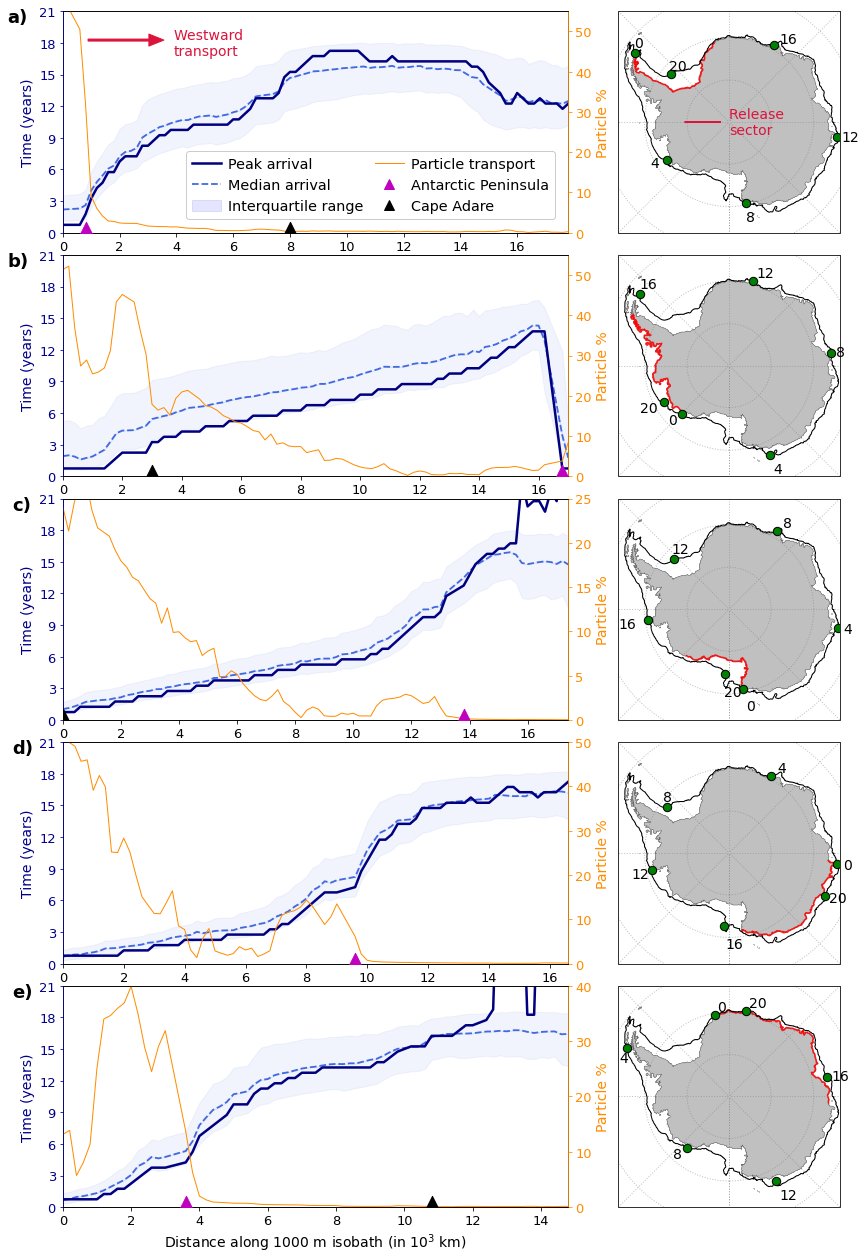

In [94]:
fig3 = plt.figure(constrained_layout=True, figsize=(14,22))
spec1 = gridspec.GridSpec(ncols=3, nrows=5, figure=fig3)
ax1 = fig3.add_subplot(spec1[0, 0:2])
ax2 = fig3.add_subplot(spec1[0, 2], projection=ccrs.SouthPolarStereo(central_longitude=0))
ax3 = fig3.add_subplot(spec1[1,0:2], )
ax4 = fig3.add_subplot(spec1[1,2], projection=ccrs.SouthPolarStereo(central_longitude=0))
ax5 = fig3.add_subplot(spec1[2,0:2],)
ax6 = fig3.add_subplot(spec1[2,2], projection=ccrs.SouthPolarStereo(central_longitude=0))
ax7 = fig3.add_subplot(spec1[3,0:2],)
ax8 = fig3.add_subplot(spec1[3,2], projection=ccrs.SouthPolarStereo(central_longitude=0))
ax9 = fig3.add_subplot(spec1[4,0:2], )
ax10= fig3.add_subplot(spec1[4,2],projection=ccrs.SouthPolarStereo(central_longitude=0) )
fig3.subplots_adjust(wspace=0.2, hspace=0.1)
#plt.rcParams.update({'font.family':'Arial'})

# East Antarctica 01
i = 0
ds = xr.open_dataset(datafiles[i])
latlon = xr.open_dataset(latlonfiles[i+2])
idxwap = (np.abs(latlon.lon - (-57))).argmin()
idxross = (np.abs(latlon.lon - (-190))).argmin()
partNo = particle_release_No[0]
twinax = time_vs_dist_plot(ds, ax9, 14.85, 21, 40, idxwap, idxross, partNo)
twinax.set_yticks([0,10,20,30,40])
twinax.set_yticklabels([0,10,20,30,40], fontsize = tickmarkfs)
twinax.spines['right'].set_color(col_pct)
twinax.yaxis.label.set_color(col_pct)
twinax.tick_params(axis='y', colors=col_pct)
twinax.spines['left'].set_color('darkblue')
ax9.yaxis.label.set_color('darkblue')
ax9.tick_params(axis='y', colors='darkblue')

stereo_plot(ax10, extent, 2)
d = 0
for i in range(6):
    idx = np.where(latlon.distance == d)[0]
    ax10.scatter(latlon.lon[idx], latlon.lat[idx], facecolor=distmarkercol, edgecolor='k', alpha=1, zorder=3,
                marker=distmarker, s=distmarkersize, transform=ccrs.PlateCarree())
    if d ==0 or d == 16 or d == 20:
        ax10.text(latlon.lon[idx]+2, latlon.lat[idx]+1, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    elif d == 4:
         ax10.text(latlon.lon[idx]-8, latlon.lat[idx]+0.5, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())   
    else:
        ax10.text(latlon.lon[idx]+3, latlon.lat[idx]+4, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    d += 4


# East Antarctica 02
i = 1
ds = xr.open_dataset(datafiles[i])
latlon = xr.open_dataset(latlonfiles[i+2])
idxwap = (np.abs(latlon.lon - (-57))).argmin()
idxross = (np.abs(latlon.lon - (-190))).argmin()
partNo = particle_release_No[1]
twinax = time_vs_dist_plot(ds, ax7, 16.65, 21, 50, idxwap,idxross, partNo)
twinax.set_yticks([0,10,20,30,40,50])
twinax.set_yticklabels([0,10,20,30,40,50], fontsize = tickmarkfs)
twinax.spines['right'].set_color(col_pct)
twinax.yaxis.label.set_color(col_pct)
twinax.tick_params(axis='y', colors=col_pct)
twinax.spines['left'].set_color('darkblue')
ax7.yaxis.label.set_color('darkblue')
ax7.tick_params(axis='y', colors='darkblue')

stereo_plot(ax8, extent, 3)
#ax4.text(-210, -80, 'Cape \nAdare', transform = ccrs.PlateCarree(), fontsize=12)
#ax4.scatter(-190, -71, marker=(3, 0, 0), s=80, c=rossmarkercol, zorder=3,transform=ccrs.PlateCarree())
#ax4.scatter(-55, -60.5, marker=(3, 0, 0), s=80, c=wapmarkercol, zorder=3,transform=ccrs.PlateCarree())
d = 0
for i in range(6):
    idx = np.where(latlon.distance == d)[0]
    #ax1.scatter(latlon.distance[idx], 0, marker=distmarker, s=distmarkersize, facecolor=distmarkercol, edgecolor='k', alpha=1,)
    ax8.scatter(latlon.lon[idx], latlon.lat[idx], facecolor=distmarkercol, edgecolor='k', alpha=1, zorder=3,
                marker=distmarker, s=distmarkersize, transform=ccrs.PlateCarree())
    if d <=8 or d == 20:
        ax8.text(latlon.lon[idx]+2, latlon.lat[idx]+1.5, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    elif i ==16:
        ax8.text(latlon.lon[idx], latlon.lat[idx]+4, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    else:
        ax8.text(latlon.lon[idx]-2, latlon.lat[idx]+5, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    d += 4

# Ross Sea
i = 2
ds = xr.open_dataset(datafiles[i])
latlon = xr.open_dataset(latlonfiles[i+2])
idxwap = (np.abs(latlon.lon - (-57))).argmin()
idxross = (np.abs(latlon.lon - (-191))).argmin()
partNo = particle_release_No[2]
twinax = time_vs_dist_plot(ds, ax5, 17.45, 21, 25, idxwap, idxross, partNo)
twinax.set_yticks([0,5,10,15,20,25])
twinax.set_yticklabels([0,5,10,15,20,25], fontsize = tickmarkfs)
twinax.spines['right'].set_color(col_pct)
twinax.yaxis.label.set_color(col_pct)
twinax.tick_params(axis='y', colors=col_pct)
twinax.spines['left'].set_color('darkblue')
ax5.yaxis.label.set_color('darkblue')
ax5.tick_params(axis='y', colors='darkblue')

stereo_plot(ax6, extent, 4)
#ax6.scatter(-190, -71, marker=(3, 0, 0), s=80, c=rossmarkercol, zorder=3,transform=ccrs.PlateCarree())
#ax6.scatter(-55, -60.5, marker=(3, 0, 0), s=80, c=wapmarkercol, zorder=3,transform=ccrs.PlateCarree())
d = 0
for i in range(6):
    idx = np.where(latlon.distance == d)[0]
    #ax1.scatter(latlon.distance[idx], 0, marker=distmarker, s=distmarkersize, facecolor=distmarkercol, edgecolor='k', alpha=1,)
    ax6.scatter(latlon.lon[idx], latlon.lat[idx], facecolor=distmarkercol, edgecolor='k', alpha=1, zorder=3,
                marker=distmarker, s=distmarkersize, transform=ccrs.PlateCarree())
    if d == 4 or d == 8 or d == 12:
        ax6.text(latlon.lon[idx]+2, latlon.lat[idx]+1.5, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    elif d == 16:
        ax6.text(latlon.lon[idx]-2, latlon.lat[idx]+7, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    else:
        ax6.text(latlon.lon[idx], latlon.lat[idx]+5, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    d += 4


# West Antarctica
i = 3
ds = xr.open_dataset(datafiles[i])
latlon = xr.open_dataset(latlonfiles[i+2])
idxwap = (np.abs(latlon.lon - (-56.8))).argmin()
idxross = (np.abs(latlon.lon - (-190))).argmin()
partNo = particle_release_No[3]
twinax = time_vs_dist_plot(ds, ax3, 17, 21, 55, idxwap, idxross, partNo)
twinax.set_yticks([0,10,20,30,40,50])
twinax.set_yticklabels([0,10,20,30,40,50], fontsize = tickmarkfs)
twinax.spines['right'].set_color(col_pct)
twinax.yaxis.label.set_color(col_pct)
twinax.tick_params(axis='y', colors=col_pct)
twinax.spines['left'].set_color('darkblue')
ax3.yaxis.label.set_color('darkblue')
ax3.tick_params(axis='y', colors='darkblue')

stereo_plot(ax4, extent, 5)
d = 0
for i in range(6):
    idx = np.where(latlon.distance == d)[0]
    #ax1.scatter(latlon.distance[idx], 0, marker=distmarker, s=distmarkersize, facecolor=distmarkercol, edgecolor='k', alpha=1,)
    ax4.scatter(latlon.lon[idx], latlon.lat[idx], facecolor=distmarkercol, edgecolor='k', alpha=1, zorder=3,
                marker=distmarker, s=distmarkersize, transform=ccrs.PlateCarree())
    if d == 8 or d == 12 or d == 16:
        ax4.text(latlon.lon[idx]+2, latlon.lat[idx]+1, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    elif d == 0 or d == 4:
        ax4.text(latlon.lon[idx]+2, latlon.lat[idx]+4, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    else:
        ax4.text(latlon.lon[idx]+2, latlon.lat[idx]+6, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    d += 4

    
# Weddell Sea
i = 4
ds = xr.open_dataset(datafiles[i])
latlon = xr.open_dataset(latlonfiles[i+2])
idxwap = (np.abs(latlon.lon - (-59))).argmin()
idxross = (np.abs(latlon.lon - (-190))).argmin()
partNo = particle_release_No[4]
twinax = time_vs_dist_plot(ds, ax1, 17.78, 21, 55, idxwap, idxross, partNo)
twinax.set_yticks([0,10,20,30,40,50])
twinax.set_yticklabels([0,10,20,30,40,50], fontsize = tickmarkfs)
twinax.spines['right'].set_color(col_pct)
twinax.yaxis.label.set_color(col_pct)
twinax.tick_params(axis='y', colors=col_pct)
twinax.spines['left'].set_color('darkblue')
ax1.yaxis.label.set_color('darkblue')
ax1.tick_params(axis='y', colors='darkblue')

stereo_plot(ax2, extent, 7)
d = 0
for i in range(6):
    idx = np.where(latlon.distance == d)[0]
    ax2.scatter(latlon.lon[idx], latlon.lat[idx], facecolor=distmarkercol, edgecolor='k', alpha=1, zorder=3,
                marker=distmarker, s=distmarkersize, transform=ccrs.PlateCarree())
    if d == 0 or d == 16 or d == 12 or d == 20:
        ax2.text(latlon.lon[idx]+2, latlon.lat[idx]+1, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    else:
        ax2.text(latlon.lon[idx]+2, latlon.lat[idx]+4, '{}'.format(d), fontsize=14,transform=ccrs.PlateCarree())
    d += 4
    
# legend
legend = twinax.legend([line1, line2, bluepatch, line3, m_triangle, k_triangle], labels, loc='upper left', ncol=2, 
                       frameon=True, bbox_to_anchor=(0.23, 0.4), fontsize = 'x-large', handletextpad=0.5, columnspacing=0.8)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 0.4))

ax9.set_xlabel('Distance along 1000 m isobath (in $10^{3}$ km)', fontsize = labelfs)

# subplot labels
ax1.text(-0.11, 0.95, subplot_labels[0], fontweight='bold', fontsize=18, transform=ax1.transAxes)
ax3.text(-0.11, 0.95, subplot_labels[1], fontweight='bold', fontsize=18, transform=ax3.transAxes)
ax5.text(-0.1, 0.95, subplot_labels[2], fontweight='bold', fontsize=18, transform=ax5.transAxes)
ax7.text(-0.1, 0.95, subplot_labels[3], fontweight='bold', fontsize=18, transform=ax7.transAxes)
ax9.text(-0.1, 0.95, subplot_labels[4], fontweight='bold', fontsize=18, transform=ax9.transAxes)

# Set xlimits
ax9.set_xlim([0,14.8])
ax7.set_xlim([0,16.6])
ax5.set_xlim([0,17.4])
ax3.set_xlim([0,17])
ax1.set_xlim([0,17.8])
ax9.set_xticklabels([0, 2,4,6,8,10,12,14], fontsize = tickmarkfs)
ax7.set_xticklabels([0, 2,4,6,8,10,12,14,16], fontsize = tickmarkfs)
ax5.set_xticklabels([0, 2,4,6,8,10,12,14,16], fontsize = tickmarkfs)
ax3.set_xticklabels([0, 2,4,6,8,10,12,14,16], fontsize = tickmarkfs)
ax1.set_xticklabels([0, 2,4,6,8,10,12,14,16], fontsize = tickmarkfs)

plot_sector_contour(ax2, ax4, ax6, ax8, ax10)
ax1.text(3.9, 16.8, 'Westward \ntransport', color='crimson',fontsize=14)
ax1.annotate('',xy=(0.2, 0.87), xytext=(0.05, 0.87),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', width=2, headwidth=12, headlength=15),
                 horizontalalignment='left', verticalalignment='center', fontsize=14)
ax2.annotate('',xy=(0.46, 0.5), xytext=(0.3, 0.5),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', width=1, headwidth=0, headlength=0.01),
                 horizontalalignment='left', verticalalignment='center', fontsize=14)
ax2.text(120, -90, 'Release \nsector', color='crimson',fontsize=14, verticalalignment='center', transform=ccrs.PlateCarree())

# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/'
outfile = outdir + 'Figure06_transittime_along_contour_5vertpanels_peakgaussian_6monthbins_countpct.jpg'
fig3.savefig(outfile, dpi=150, bbox_inches='tight')